# LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [8]:
import numpy as np
import pandas as pd
#!pip install hvplot
import hvplot.pandas

In [7]:
# Set the random seed for reproducibility
from numpy.random import seed 
seed(1)
#!pip install tensorflow
from tensorflow import random 
random.set_seed(2)

In [9]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [10]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2 = df2.to_frame()
df2.tail()

,Close
Date,
2019-07-25,9882.429688
2019-07-26,9847.450195
2019-07-27,9478.320313
2019-07-28,9531.769531
2019-07-29,9529.889648


In [11]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [12]:
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [13]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1) # It returns a numpy array of X any y

In [14]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 3

# Column index 0 is the 'fng_value' column & column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [16]:
# Use 70% of the data for training and the remaineder for testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)

# Make x splits
X_train_split = int(0.7 * len(X))
X_train = X[: X_train_split]
X_test_split = int(0.3 * len(X))
X_test = X[X_test_split :]

# Make y splits
y_train_split = int(0.7 * len(y))
y_train = y[: y_train_split]
y_test_split = int(0.3 * len(y))
y_test = y[y_test_split:]

In [17]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler() # Default is already feature_range=0,1

# Training sets
x_scaler.fit(X_train)
y_scaler.fit(y_train)

# Scaling for X sets
#scaler = scaler.fit(X)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

# Scaling for y sets. y is already vertical so that's why I don't need to reshape that data
#scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [18]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [20]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features
model = Sequential()

num_unitz = 30 # This parameter is okay to change. 
drop_prct = .23 
# Layer 1
model.add(LSTM(units=num_unitz, return_sequences=True, input_shape = ((X_train.shape[1], 1)))) 
# 3D array is as follows = (batch_size of 3, time steps of 1, & number of units in 1 input sequence)
model.add(Dropout(drop_prct))
# Layer 2
model.add(LSTM(units=num_unitz, return_sequences=True))
model.add(Dropout(drop_prct)) 
# Layer 3
model.add(LSTM(units=num_unitz))
model.add(Dropout(drop_prct))
# Output Layer
model.add(Dense(1))

In [21]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 30)             3840      
                                                                 
 dropout (Dropout)           (None, 3, 30)             0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 30)             7320      
                                                                 
 dropout_1 (Dropout)         (None, 3, 30)             0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [23]:
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
377/377 [==============================] - 20s 11ms/step - loss: 0.0447
Epoch 2/10
377/377 [==============================] - 4s 12ms/step - loss: 0.0210
Epoch 3/10
377/377 [==============================] - 5s 12ms/step - loss: 0.0203
Epoch 4/10
377/377 [==============================] - 5s 12ms/step - loss: 0.0172
Epoch 5/10
377/377 [==============================] - 4s 12ms/step - loss: 0.0151
Epoch 6/10
377/377 [==============================] - 5s 12ms/step - loss: 0.0145
Epoch 7/10
377/377 [==============================] - 4s 12ms/step - loss: 0.0111
Epoch 8/10
377/377 [==============================] - 5s 12ms/step - loss: 0.0110
Epoch 9/10
377/377 [==============================] - 4s 12ms/step - loss: 0.0108
Epoch 10/10
377/377 [==============================] - 4s 12ms/step - loss: 0.0100


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [24]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.028953945264220238

In [25]:
# Make some predictions
X_predictionz = model.predict(X_test)

In [26]:
# Recover the original prices instead of the scaled version
predicted_prices = y_scaler.inverse_transform(X_predictionz)
real_prices = y_scaler.inverse_transform(y_test.reshape(-1, 1))

In [27]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2018-07-19,7383.390137,5694.971680
2018-07-20,7477.500000,5930.073242
2018-07-21,7333.930176,6115.809082
2018-07-22,7405.399902,6136.958496
2018-07-23,7398.640137,6142.313477


<AxesSubplot:title={'center':'Real prices vs. Predictions'}>

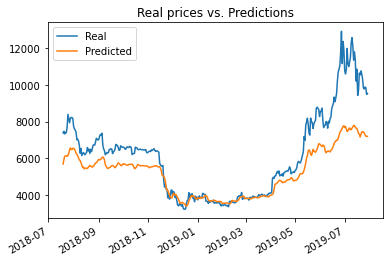

In [28]:
# Plot the real vs predicted values as a line chart
stocks.plot(title="Real prices vs. Predictions")